# Installing Packages

In [1]:
using Plots, Statistics, FinancialToolbox, Dates, ForwardDiff, Distributions
using Random, DiffEqBase.EnsembleAnalysis, Flux, Optimization, OptimizationFlux, DiffEqFlux, StochasticDiffEq, SciMLBase.EnsembleAnalysis
Random.seed!(1)

TaskLocalRNG()

# Initialising the Neural SDE
We specify the following underlying SDE: <br>
$dS_t = rS_tdt + \sigma S_t^\alpha dW_t$ <br>
$S_0 = 100$ <br>
$r = 8\%$ <br>
$\sigma = 200\%$ <br>
$\alpha \in [0,1]$, So the stock model produces behaviour consistent with the leverage effect.  <br>
$\alpha = 0.5$, a square root process - similar to CIR without mean reversion, has an analytical solution for stock prices. <br>

In [2]:
S₀ = Float32[100.]  # Initial value of the SDE.
r = 0.08 # Risk-free rate of interest.
σ = 2 # Volatility. 
α = 0.5
datasize = 30 # The size of the solution/stock paths we want to calculate. 
tspan = (0.0f0, 1.0f0) # The time horizon we wish to obtain the stock path over. 
tsteps = range(tspan[1], tspan[2], length = datasize) # Each time step we want a stock price. 


function CEV_Drift(du, S, p, t) # Drift function of GBM. 
    du .= r*S
end


function CEV_Diffusion(du, S, p, t) # Diffusion function of GBM. 
    du .= σ*S.^α
end

CEV = SDEProblem(CEV_Drift, CEV_Diffusion, S₀, tspan) # Specifying the GBM. 

SDEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 1.0f0)
u0: 1-element Vector{Float32}:
 100.0

# Pre-training drift coefficent
We pre-train the drift coefficent to be consistent with the no-arbitrage requirements.

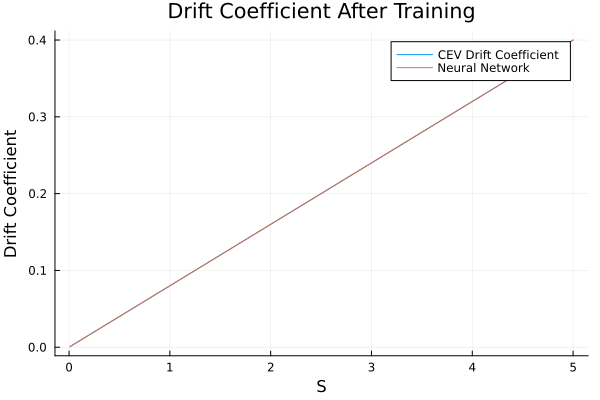

In [3]:
# Pre training the drift coefficient, no-arbitrage condition
gridsize = 1000;
Func(x) = r*x;
X_Training = collect(range(0,stop=10,length=gridsize));
Y_Training = Func.(X_Training);

X_Testing = collect(range(0.01,stop=5,length=gridsize));
Y_Testing = Func.(X_Testing)

data = []
for i in 1:length(X_Training)
    push!(data, ([X_Training[i]], Y_Training[i]))
end

Pre_NSDE_Drift = Flux.Chain(Flux.Dense(1,1))
plt1 = plot(X_Testing ,[Y_Testing  Pre_NSDE_Drift(X_Testing')'],title="Diffusion Coefficient Before Training",label=["CEV Diffusion Coefficient" "Neural Network"], xlabel = "S",ylabel = "Diffusion Coefficient") # before training

loss_drift(x, y) = Flux.mse(Pre_NSDE_Drift(x), y)
opt_drift = Descent(0.01)
ps = Flux.params(Pre_NSDE_Drift)

for epoch in 1:500 
    Flux.train!(loss_drift, ps, data, opt_drift);
end

plt3 = plot(X_Testing ,[Y_Testing Pre_NSDE_Drift(X_Testing')'],title="Drift Coefficient After Training",label=["CEV Drift Coefficient" "Neural Network"], xlabel = "S",ylabel = "Drift Coefficient") # before training


In [4]:
p1, re1 = Flux.destructure(Pre_NSDE_Drift)
Q = 16; 
Pre_NSDE_Diffusion = Flux.Chain(Flux.Dense(1,Q,elu),Flux.Dense(Q,Q,elu),Flux.Dense(Q,1));  
p2, re2 = Flux.destructure(Pre_NSDE_Diffusion)

Pre_NSDE = NeuralDSDE(Pre_NSDE_Drift , Pre_NSDE_Diffusion, tspan, SOSRI(), saveat = tsteps, reltol = 1e-1, abstol = 1e-1) # Specifying the neural SDE.

NeuralDSDE()

# Specifying the Training and Testing Data
We use the closed-form CEV call option pricing formulae to generate a training data set.

In [31]:
K = range(70, 130, length = 1000)
function C(S0, r, σ, T, K, α)
k = 2*r./(σ.^2 * (1 - α) * (exp(2*r * (1 - α) * T) - 1))
x = k * S0.^(2 * (1 - α)) * exp(2*r * (1 - α) * T)
x = x[1]
y = k * K.^(2 * (1 - α))
z = 2 + 1 / (1 - α)
non_central_chi_square = NoncentralChisq(z, x)
X_x = cdf(non_central_chi_square, y)
X_y = cdf(NoncentralChisq(z - 2, y), x)
return S0 * (1 .- X_x) .- K * exp(-r * T) * X_y
end



CEV_Price = zeros(1,length(K)) 

for i in 1:length(K)
    A = C(S₀, r, σ, tspan[2], K[i], α)
    CEV_Price[i] = A[1]
end

CEV_Price = CEV_Price[1,:];

# Training the Neural SDE

In [36]:
function predict_neuralsde(p, u = S₀) 
  return Array(Pre_NSDE(u, p)) # Returns an array of stock prices/SDE solutions at each time point. 
end

function loss_neuralsde(p; n = 10000)
u = repeat(reshape(S₀, :, 1), 1, n)
stock = predict_neuralsde(p,u)[1,:,end]
    
NSDE_call = map(i->exp(-r*tspan[2]).*mean(maximum([stock .- K[i] zeros(size(stock))], dims = 2)),1:length(K))

loss = sum(abs2, NSDE_call - CEV_Price)  
 return loss , NSDE_call  
end   

loss_neuralsde (generic function with 1 method)

In [37]:
list_plots = []
iter = 0
loss1 = zeros(1,10000)
# Callback function to observe training
callback = function (p, loss, NSDE_call; doplot = false)
  global list_plots, iter

  if iter == 0
    list_plots = []
  end
  iter += 1

  # loss against current data
  display(loss)
    display(iter)
     loss1[iter] = loss

  return false
end

#34 (generic function with 1 method)

In [38]:
t1 = now()

opt = ADAM()

# First round of training with n = 10000
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=10000), adtype)
optprob = Optimization.OptimizationProblem(optf, Pre_NSDE.p)
result1 = Optimization.solve(optprob, opt, callback = callback, maxiters = 50)  # 50 iterations of training. 

13195.699006908422

1

12097.69103569944

2

10910.065741670338

3

9936.969717038182

4

8861.284109167724

5

7623.533289675164

6

6182.028454084023

7

5434.000989763863

8

4038.5939648132453

9

3126.3616590619677

10

2298.9632991840326

11

1806.3664263254184

12

887.2506598510913

13

667.2460858308405

14

457.59761632500977

15

330.12589903496945

16

526.2728828255969

17

467.53703307834286

18

685.06578501363

19

654.1837681967916

20

1282.4018459107342

21

1268.7634991849302

22

1357.879743013282

23

1634.9844796482953

24

887.01524164995

25

1090.5638763437923

26

1059.503233304755

27

544.5147316112706

28

240.25955299972472

29

873.0750656011711

30

89.0796488830656

31

370.55295620104584

32

185.00344871310614

33

193.87103014835336

34

196.0905592994224

35

238.45693259787743

36

248.19702988530236

37

243.59125391866428

38

345.0863600657651

39

411.5317365381471

40

358.62090728068944

41

335.99916503836306

42

252.38465328901341

43

227.28213682409813

44

267.5846052789531

45

169.2406471940587

46

122.12777468563937

47

191.4439368612634

48

62.69166854899327

49

50.681871188862

50

50.681871188862

51

u: 323-element Vector{Float32}:
  0.08634488
  0.0062712673
 -0.4555023
 -0.45259923
 -0.34068492
 -0.12572336
  0.277264
 -0.56546026
 -0.06524965
  0.24324891
 -0.1234799
  0.33423963
  0.083634935
  ⋮
 -0.2140486
  0.0119946785
 -0.054906834
 -0.14151384
  0.14891738
 -0.3160822
  0.14265558
 -0.16205586
 -0.21138245
 -0.53436583
 -0.49640176
 -0.016123436

In [39]:
t2 = now()
time = t2 - t1 

226391 milliseconds

In [40]:
prob = result1.u
u1 = repeat(reshape(S₀, :, 1), 1, 100000)
a = predict_neuralsde(prob, u1)[1,:,:]
stock_price_NSDE = a[:,end]
NSDE_call_NSDE = map(i->exp(-r*tspan[2]).*mean(maximum([stock_price_NSDE .- K[i] zeros(size(stock_price_NSDE))], dims = 2)),1:length(K));

In [42]:
# Resume training
t3 = now()

optf2 = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=50000), adtype)
optprob2 = Optimization.OptimizationProblem(optf2, result1.u)
result2 = Optimization.solve(optprob2, opt, callback = callback, maxiters = 50)

64.58360763562337

52

91.04688890738069

53

99.38816463521103

54

47.90295120396906

55

42.036236287243995

56

33.878496816457776

57

37.2197932198309

58

26.34271095034069

59

36.24097565857228

60

13.74854249906036

61

15.499101157257543

62

13.537985555533162

63

17.731213544988606

64

11.281553312209198

65

12.443873681701847

66

18.731890187185833

67

14.951941725997004

68

11.411750253889211

69

18.875166107463915

70

17.46841089972345

71

16.416884385722344

72

15.657742455146607

73

15.084507730284884

74

19.3063965852882

75

51.40116814056001

76

17.82631301880693

77

15.53664212652295

78

11.48817779838646

79

16.20965660382772

80

15.74715604141725

81

13.993509828419446

82

35.286280779778515

83

11.435411788601861

84

24.641593105791085

85

22.308149878271113

86

25.128687720788182

87

38.36293713501605

88

17.704161676154243

89

19.679900858140734

90

40.04271032150204

91

20.72577597419907

92

35.604748696469215

93

30.78805774787714

94

34.682175786746846

95

22.400509673418775

96

27.606482581474825

97

56.68362166526672

98

65.56181243069972

99

21.43174239904849

100

15.521430924388712

101

11.281553312209198

102

u: 323-element Vector{Float32}:
  0.081967846
  0.0017418033
 -0.45550132
 -0.45259884
 -0.34128547
 -0.12870577
  0.2782905
 -0.56546026
 -0.0655923
  0.24432564
 -0.12635031
  0.33538264
  0.0847805
  ⋮
 -0.2151685
  0.013080929
 -0.05534068
 -0.14039043
  0.14720596
 -0.31695142
  0.14143914
 -0.1631394
 -0.21029057
 -0.5354366
 -0.4953099
 -0.017215323

In [43]:
t4 = now()
time1 = t4 - t3 

1317695 milliseconds

In [44]:
# Resume training
t5 = now()

optf3 = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x, n=100000), adtype)
optprob3 = Optimization.OptimizationProblem(optf3, result2.u)
result3 = Optimization.solve(optprob3, opt, callback = callback, maxiters = 50)

19.06936632606646

103

121.81881357863074

104

16.953792911373405

105

18.882482758559355

106

38.768452343019014

107

23.164307772973427

108

17.337117614056616

109

11.725623490717924

110

10.099103604595495

111

9.92602097215208

112

10.597820442182275

113

13.192709057041197

114

11.828917970027836

115

10.576035290246809

116

14.632819391436652

117

10.989291422059464

118

17.21264462254986

119

10.859274451679404

120

13.075508007971322

121

12.040962944175734

122

13.069796024074806

123

15.603414137102549

124

22.20176083962421

125

11.911391445007068

126

10.70922192871963

127

13.717638346228918

128

14.11722489737776

129

14.589387204376582

130

15.524594300748824

131

12.058347571620871

132

14.526436853049018

133

11.793935072217852

134

15.541785640279851

135

11.246278703108413

136

14.585135113660948

137

12.661701042662974

138

12.957989139302487

139

10.527060212231346

140

11.448734628954245

141

19.27712675199104

142

13.642890307432255

143

15.105870934308028

144

17.822152419529704

145

13.688482557273508

146

13.755921428985268

147

25.602277542608064

148

10.124954087556793

149

12.198860331265129

150

11.987684437805523

151

35.87749935709694

152

9.92602097215208

153

u: 323-element Vector{Float32}:
  0.08296705
  0.0027941468
 -0.45550105
 -0.4525988
 -0.34138697
 -0.12751995
  0.2782472
 -0.56546026
 -0.06692598
  0.2443036
 -0.12516753
  0.33540422
  0.084803045
  ⋮
 -0.21517324
  0.01331642
 -0.054947775
 -0.14014868
  0.1468272
 -0.31682697
  0.14136575
 -0.1631224
 -0.21004842
 -0.53541964
 -0.49506775
 -0.017457483

In [45]:
t6 = now()
time1 = t6 - t5

2944395 milliseconds

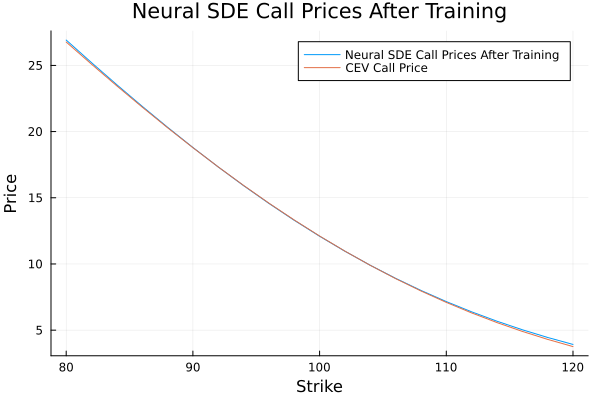

In [276]:
prob1 = result3.u
u2 = repeat(reshape(S₀, :, 1), 1, 100000)
a1 = predict_neuralsde(prob1, u2)[1,:,:]
stock_price_NSDE1 = a1[:,end]
K = range(80, 120, length = 21)
CEV_Price1 = zeros(1,length(K)) 

for i in 1:length(K)
    A = C(S₀, r, σ, tspan[2], K[i], α)
    CEV_Price1[i] = A[1]
end


NSDE_call_NSDE1 = map(i->exp(-r*tspan[2]).*mean(maximum([stock_price_NSDE1 .- K[i] zeros(size(stock_price_NSDE1))], dims = 2)),1:length(K))
plot(K,NSDE_call_NSDE1,title="Neural SDE Call Prices After Training",label = "Neural SDE Call Prices After Training",xlabel = "Strike",ylabel = "Price")
plt3 = plot!(K,CEV_Price1',title="Neural SDE Call Prices After Training",label = "CEV Call Price",xlabel = "Strike",ylabel = "Price")

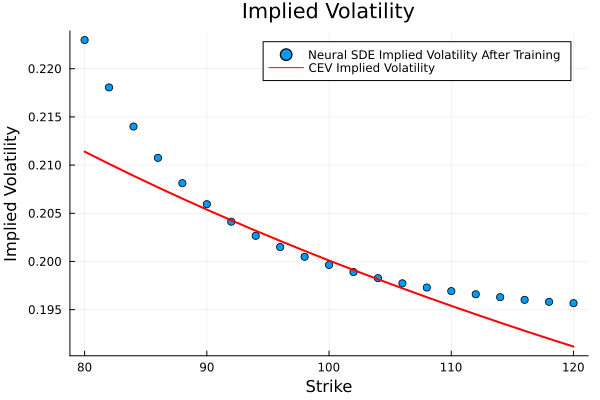

In [277]:
K = range(80, 120, length = 21)
CEV_Vol = zeros(1,length(K))
Vol_After = zeros(1,length(K))

for i in 1:length(K)
    CEV_Vol[i] = blsimpv(100,K[i],r,tspan[2],CEV_Price1[i])
    Vol_After[i] = blsimpv(100,K[i],r,tspan[2],NSDE_call_NSDE1[i])
end 
plt19 = scatter(K,Vol_After',title="Call Prices",label = "Neural SDE Implied Volatility After Training",xlabel = "Strike",ylabel = "Implied Volatility");
scatter(plt19)
plt11 = plot!(K,CEV_Vol', linewidth=2,c=:red,title="Implied Volatility",label = "CEV Implied Volatility")


# Plotting

In [281]:
using Gadfly, Fontconfig, Cairo, DataFrames, Compose, ColorSchemes, LinearAlgebra, Base;

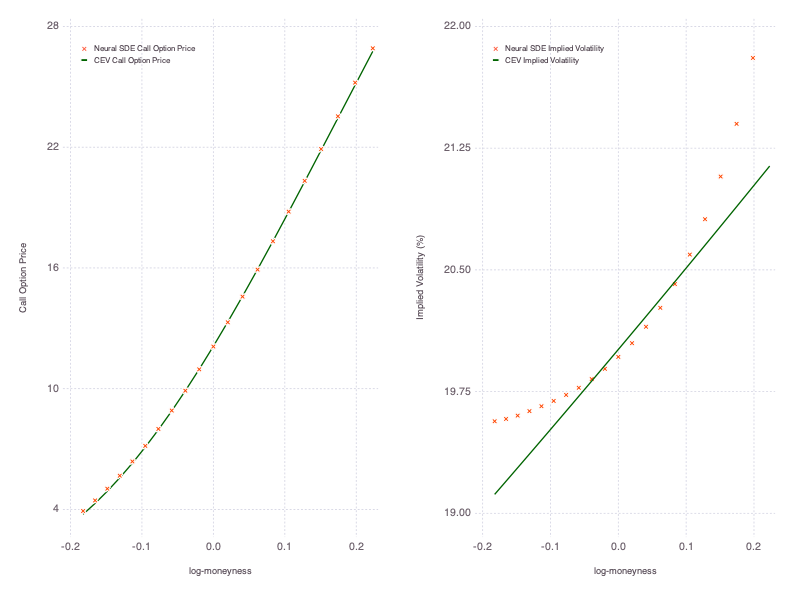

In [637]:
# Plotting call prices
K1 = 100 ./ range(80, 120, length = 21)
K1 = K1[:,1]
log_moneyness = log.(K1)

NSDE_Call_Prices = NSDE_call_NSDE1;
CEV_Call_Prices = CEV_Price1[1,:];
NSDE_Call_Vol = Vol_After[1,:].*100;
CEV_Call_Vol = CEV_Vol[1,:].*100;

layer7 = layer(x= log_moneyness, y=NSDE_Call_Prices,Geom.point,shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=CEV_Call_Prices,Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
p5 = Gadfly.plot(layer7,layer8,Guide.yticks(ticks = [ 4    10    16    22    28]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Call Option Price"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Call Option Price","CEV Call Option Price"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=3, ymax=28))


layer9 = layer(x=log_moneyness, y= NSDE_Call_Vol,Geom.point, shape=[Gadfly.Shape.xcross],Theme(point_size =2.5pt,default_color=colorant"#FF4500"))
layer8 = layer(x=log_moneyness, y=CEV_Call_Vol, Geom.line,Theme(line_width = 1pt,default_color=colorant"#006400"))
p6 = Gadfly.plot(layer8,layer9,Guide.yticks(ticks = [19.0000   19.7500   20.5000   21.2500 22]),Theme(key_label_font_size=6pt,major_label_font_size=7pt),Guide.ylabel("Implied Volatility (%)"), Guide.xlabel("log-moneyness"),Guide.manual_color_key("", ["Neural SDE Implied Volatility","CEV Implied Volatility"],["#FF6347","#006400"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.xcross, Gadfly.Shape.hline]),Coord.cartesian(xmin=-0.2, xmax=0.22, ymin=18.9, ymax=22))#draw(PDF("myplot20.pdf", 14cm, 7cm), plt)
plt = hstack(p5,p6)
#draw(PDF("myplot.pdf", 14cm, 7cm), plt)

In [678]:
prob1 = result3.u
n1 = 1000
u2 = repeat(reshape(S₀, :, 1), 1, n1)
y = predict_neuralsde(prob1, u2)[1,:,:]'
y1 = y[end,:]
m = S₀.*exp.(r.*1)
y_sort = y[:, sortperm(y[end,:])];
m = m[1]

108.32870676749586

In [726]:
n2 = 1000000
u3 = repeat(reshape(S₀, :, 1), 1, n2)
y3 = predict_neuralsde(prob1, u3)[1,:,:]'
y4 = y3[end,:];

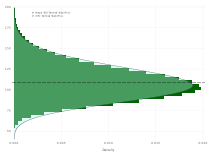

In [729]:
lambda = -(4*0.08*exp(0.08))/(4*(1-exp(0.08)))*100
LN = NoncentralChisq(0.00001,lambda)*(-4(1-exp(0.08))/(4*0.08))
s =  40:0.005:200
s = s[:,1]
LNPDF = pdf.(LN,s)

layer1 = layer(y=s, x=LNPDF, xmin=zeros(size(LNPDF)),Geom.path , Theme(alphas=[0.4], default_color=colorant"#2F4F4F") , xmax= LNPDF ,Geom.ribbon)
layer2 = layer(yintercept=[m], Geom.hline(color=["black"],style=[:dash]))
hist_plt = Gadfly.plot(layer2, layer1,
    y=y4,Guide.yticks(ticks = [50 75 100 125 150 175 200]), Geom.histogram(density=true, bincount=60, orientation=:horizontal), 
    Guide.xlabel("Density"), Guide.ylabel(nothing),Guide.manual_color_key("", ["Neural SDE Terminal Stock Price","CEV Terminal Stock Price"],["#006400","#2F4F4F"],pos=[0.1w,-0.45h],shape=[Gadfly.Shape.hline,Gadfly.Shape.hline]),
    Theme(key_label_font_size=6.5pt, major_label_font_size=9pt, key_position=:none, default_color=colorant"#006400"),Coord.cartesian(xmin=0, xmax=0.02, ymin=40, ymax=200))



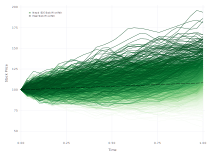

In [732]:

tsteps = range(tspan[1], tspan[2], length = datasize)
CEV_Means = S₀.*exp.(r.*tsteps)
CEV_Means = convert(Vector{Float32}, CEV_Means)

layer1 = Gadfly.layer(x = tsteps,y = CEV_Means, Geom.line,linestyle=[:dash],color=[colorant"black"])

layer2 = Gadfly.layer(y_sort, x=repeat(tsteps, inner=n1), y=Col.value, color=Col.index, Geom.line)
stock_path_plt = Gadfly.plot(layer1,layer2,Guide.xlabel("Time"),Guide.ylabel("Stock Price")
    ,Guide.xticks(ticks = [0 0.25 0.5 0.75 1]),Guide.yticks(ticks = [50 75 100 125 150 175 200])
    , Scale.ContinuousColorScale(p -> get(ColorSchemes.:Greens, p)),Theme(key_label_font_size=6.5pt,major_label_font_size=9pt,key_position = :none),Guide.manual_color_key("", ["Neural SDE Stock Price Path","Mean Stock Price Path"],["#006400","#000000"],pos=[0.05w,-0.45h],shape=[Gadfly.Shape.hline,Gadfly.Shape.hline]),Coord.cartesian(xmin=0, xmax=1, ymin=40, ymax=200))
#:YlOrBr_6

In [734]:
M = Array{Compose.Context}(undef, 1, 2)
M[1] = compose(context(0,0,2/3,1), render(stock_path_plt))
M[2] = compose(context(0,0,1/3,1), render(hist_plt))
plt_main = hstack(M[1],M[2])
draw(PDF("myplot1.pdf", 18cm, 10cm), plt_main)